# III. Regression linéaire sur les retards de la SNCF V2

<span style="color: #D32F2F">**1. Importation de modules nécessaires et des données**</span>

In [1]:
#Importation des modules nécessaires pour la visualisation
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
#Importation des modules nécessaires pour la modélisation
import statsmodels.api as sm
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [3]:
#Importation des fonctions créées pour le projet
from fonctions import *

In [4]:
"""
#si erreur "Max retries exceeded with url" dans la cellule suivante, utiliser cette cellule

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

session.get(url_retards)
"""

'\n#si erreur "Max retries exceeded with url" dans la cellule suivante, utiliser cette cellule\n\nimport requests\nfrom requests.adapters import HTTPAdapter\nfrom urllib3.util.retry import Retry\n\nsession = requests.Session()\nretry = Retry(connect=3, backoff_factor=0.5)\nadapter = HTTPAdapter(max_retries=retry)\nsession.mount(\'http://\', adapter)\nsession.mount(\'https://\', adapter)\n\nsession.get(url_retards)\n'

In [5]:
#Importation des données depuis l'API SNCF
df_retards = importer('https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC')
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BREST,PARIS MONTPARNASSE,225,284,3,None,4,2.250000,...,19,5.370390,5,2,33.333333,53.333333,0.000000,13.333333,0.000000,0.0
1,2018-01,National,PARIS MONTPARNASSE,ANGOULEME,126,239,4,None,36,6.347685,...,15,4.113191,3,0,15.384615,38.461538,19.230769,23.076923,3.846154,0.0


<span style="color: #D32F2F">**2. nettoyage et préparation des données pour la regression**</span>

In [6]:
#Elimination des colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)

In [7]:
#on retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']==0].index)

In [8]:
#Listage des différentes causes de retards du dataframe
causes_retards = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs']
causes_retards_large = ['nb_annulation', 'cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_prevu']

In [9]:
#On passe les causes de retards en niveau plutôt qu'en pourcentage pour homogénéiser les données
#On utilise pour cela la fonction niveau qui est dans le fichier fonctions.py
niveau(df_retards,df_retards['nb_train_retard_arrivee'], causes_retards)


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,BREST,PARIS MONTPARNASSE,225,284,3,4,2.250000,0.032028,...,0.000000,13.333333,0.000000,0.000000,2.533333,10.133333,0.000000,6.333333,0.000000,0.000000
1,2018-01,National,PARIS MONTPARNASSE,ANGOULEME,126,239,4,36,6.347685,0.751560,...,19.230769,23.076923,3.846154,0.000000,6.461538,10.769231,5.384615,4.307692,1.076923,0.000000
2,2018-01,National,PARIS MONTPARNASSE,POITIERS,93,506,4,62,7.717742,0.644090,...,11.538462,19.230769,0.000000,0.000000,10.000000,22.000000,6.000000,14.000000,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,TOURS,72,186,0,30,9.582778,1.093907,...,11.538462,19.230769,3.846154,0.000000,9.230769,22.153846,5.538462,9.230769,1.846154,0.000000
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,14.052632,40.596491,17.175439,14.052632,1.561404,1.561404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,2022-11,National,PARIS MONTPARNASSE,RENNES,97,764,0,87,14.108238,1.170441,...,13.978495,25.806452,11.827957,4.301075,24.258065,17.182796,13.139785,24.258065,11.118280,4.043011
7301,2022-11,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,63,524,0,48,16.227431,1.056711,...,20.454545,18.181818,4.545455,13.636364,8.363636,10.454545,9.409091,9.409091,2.090909,6.272727
7302,2022-11,National,PARIS MONTPARNASSE,TOURS,74,176,1,16,16.914583,0.784571,...,18.750000,18.750000,6.250000,12.500000,3.187500,4.250000,3.187500,3.187500,1.062500,2.125000
7303,2022-11,National,POITIERS,PARIS MONTPARNASSE,104,445,2,172,7.686434,2.809050,...,12.500000,20.833333,0.000000,8.333333,10.000000,16.000000,6.000000,12.000000,0.000000,4.000000


In [10]:
#Copie du dataframe initiale (par securité)
df_retards_initial = df_retards.copy()

In [11]:
#Recalibrage des données 

features = df_retards[causes_retards_large]
features = StandardScaler().fit(features.values).transform(features.values)
df_retards[causes_retards_large] = features
df_retards


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,BREST,PARIS MONTPARNASSE,225,0.158799,-0.283086,4,2.250000,0.032028,...,0.000000,13.333333,0.000000,0.000000,-0.585035,0.285944,-0.856305,-0.204954,-0.763213,-0.611973
1,2018-01,National,PARIS MONTPARNASSE,ANGOULEME,126,-0.107343,-0.244192,36,6.347685,0.751560,...,19.230769,23.076923,3.846154,0.000000,0.000604,0.361023,-0.208426,-0.419109,-0.419152,-0.611973
2,2018-01,National,PARIS MONTPARNASSE,POITIERS,93,1.471766,-0.244192,62,7.717742,0.644090,...,11.538462,19.230769,0.000000,0.000000,0.528138,1.687007,-0.134383,0.605579,-0.763213,-0.611973
3,2018-01,National,PARIS MONTPARNASSE,TOURS,72,-0.420800,-0.399767,30,9.582778,1.093907,...,11.538462,19.230769,3.846154,0.000000,0.413457,1.705171,-0.189915,0.101368,-0.173395,-0.611973
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,1.270681,-0.244192,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,1.132327,3.882641,1.210250,0.611144,-0.264368,-0.228773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,2022-11,National,PARIS MONTPARNASSE,RENNES,97,2.997647,-0.399767,87,14.108238,1.170441,...,13.978495,25.806452,11.827957,4.301075,2.653811,1.118254,0.724679,1.690080,2.788910,0.380263
7301,2022-11,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,63,1.578223,-0.399767,48,16.227431,1.056711,...,20.454545,18.181818,4.545455,13.636364,0.284180,0.323869,0.275800,0.120220,-0.095199,0.927481
7302,2022-11,National,PARIS MONTPARNASSE,TOURS,74,-0.479942,-0.360874,16,16.914583,0.784571,...,18.750000,18.750000,6.250000,12.500000,-0.487508,-0.408684,-0.472784,-0.537537,-0.423760,-0.090455
7303,2022-11,National,POITIERS,PARIS MONTPARNASSE,104,1.110996,-0.321980,172,7.686434,2.809050,...,12.500000,20.833333,0.000000,8.333333,0.528138,0.978604,-0.134383,0.394136,-0.763213,0.369708


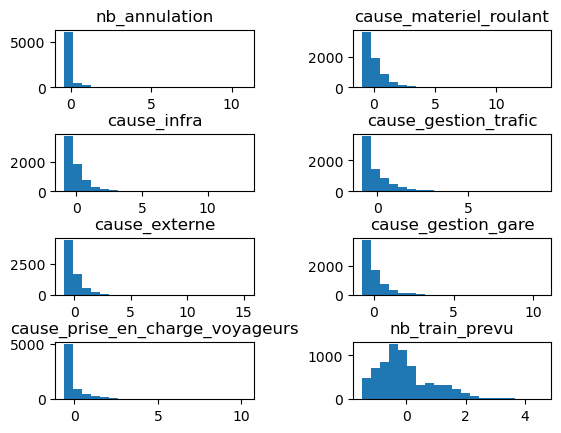

In [12]:
#Visualisation des données
for i in range(len(causes_retards_large[:])):
    plt.subplot(4,2,i+1)
    plt.hist(df_retards[causes_retards_large[i]], bins = 20)
    plt.title(causes_retards_large[i])
    plt.gcf().subplots_adjust(wspace = 0.5, hspace = 0.8)

In [13]:
#Les données sont correctes, nous ne passerons pas au log ici

<span style="color: #D32F2F">**3. Modélisation : première regression à une variable**</span>

Regression "rapide", pour récupérer le R^2, car nous nous intéresserons plus longuement au cas multivarié

In [14]:
#Appel de la fonction régression du fichier fonctions.py

results_s = regression(df_retards[['cause_externe']], df_retards[['nb_train_retard_arrivee']])
print(results_s.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     9288.
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:31:12   Log-Likelihood:                -31378.
No. Observations:                7144   AIC:                         6.276e+04
Df Residuals:                    7142   BIC:                         6.277e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.7203      0.231    150.042

Le R^2, caractéristique du pouvoir explicatif du modèle, est d'environ 0.56 (1 correspondant à une prédiction parfaite). La variable cause_externe est significative.


<span style="color: #D32F2F">**4. Modélisation : régression à plusieurs variables**</span>

In [15]:
#On passe maintenant à une regression à plusieurs variables
results = regression(df_retards[causes_retards_large], df_retards[['nb_train_retard_arrivee']])
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 6.009e+04
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:31:13   Log-Likelihood:                -19262.
No. Observations:                7144   AIC:                         3.854e+04
Df Residuals:                    7135   BIC:                         3.860e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [16]:
#Modélisation finale : on retire les variables non significatives
results = regression(df_retards[causes_retards], df_retards[['nb_train_retard_arrivee']])
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 8.007e+04
Date:                Mon, 19 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:31:13   Log-Likelihood:                -19265.
No. Observations:                7144   AIC:                         3.854e+04
Df Residuals:                    7137   BIC:                         3.859e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     


**Analyse des coefficients**

Le R^2 de la regression est satisfaisant et a largement augmenté (en ajoutant des variables, on augmente le pouvoir explicatif du modèle sous certaines conditions). La variable nb_annulation n'est pas significative et nb_train_prevu n'est pas significative au seuil de 1%. Le reste des variables sont significatives.
Le coefficient le plus élevé est celui de cause_externe. Il signifie qu'une cause externe provoque le retard d'environ 9 trains en moyenne. 

**Conclusion** : selon cette regression, l'incident impliquant le plus de retard est la cause externe (météo...). Lorsqu'on observe un incident externe de plus, on prédit le retard de 9 à 10 trains supplémentaires. Malheureusement, la SNCF ne peut pas vraiment agir sur ce genre d'incidents. 
En revanche, si la SNCF trouvait par exemple un moyen de supprimer les problèmes de matériel roulant, elle éviterait le retard de 6 à 7 trains par ligne et par mois. 
Ce qui est plus embêtant pour la SNCF est qu'aucune cause de retard ne "sort du lot" en terme d'impact donc la SNCF doit agir sur l'ensemble de ces causes pour réduire les retards.


<span style="color: #D32F2F">**5. Prédiction**</span>

In [17]:
df_retards.loc[:,'log_nb_train_retard_arrivee']  = np.log(df_retards['nb_train_retard_arrivee'])

In [18]:
#Elimination des valeurs excessives
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']>170].index)
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']==1].index)

intercept :  3.1944903699492087
coeffs :  [0.23628321 0.21513706 0.20291537 0.28208002 0.10845471 0.1099466 ]
rsq :  0.7383561110323364
rmse :  0.45472343979436464



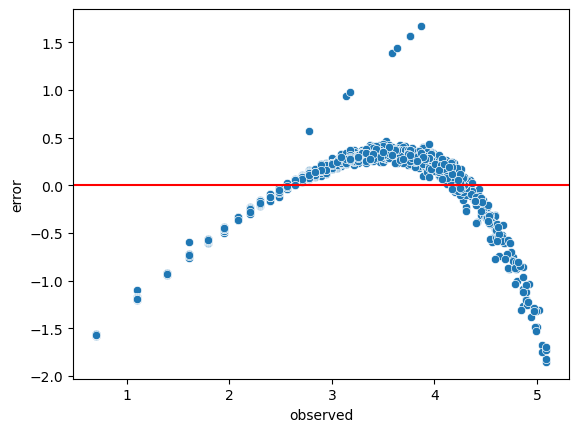

In [19]:
x = df_retards[causes_retards]
y = df_retards['log_nb_train_retard_arrivee']

prediction(x, y)
print()

In [20]:
#Le modèle souffre d'un problème de spécification

<span style="color: #D32F2F">**6. Sélection de variables avec le lasso**</span>

In [34]:
#Estimation du modèle LASSO
X_train = prediction(x, y, afficher = False)[0]
y_train = prediction(x, y, afficher = False)[1]

lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.00655).fit(X_train,y_train)

#selection de variables
features_selec = x.columns[np.abs(lasso1.coef_)>0].tolist()
features_selec 


/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


['cause_infra', 'cause_gestion_trafic', 'cause_prise_en_charge_voyageurs']

In [36]:
#Refaire tourner la cellule précédente si elle ne sélectionne aucune variable

In [37]:
#corrélations entre les variables sélectionnées
corr = df_retards[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
p

/tmp/ipykernel_1423/2425215618.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,cause_infra,cause_gestion_trafic,cause_prise_en_charge_voyageurs
cause_infra,1.00,0.54,0.28
cause_gestion_trafic,0.54,1.00,0.34
cause_prise_en_charge_voyageurs,0.28,0.34,1.00


<Figure size 640x480 with 0 Axes>

On vérifie que les variables ne sont pas exagérément correlées;

intercept :  3.193419380375069
coeffs :  [0.37969397 0.3694845  0.19914384]
rsq :  0.5998684480142872
rmse :  0.5767916485178184



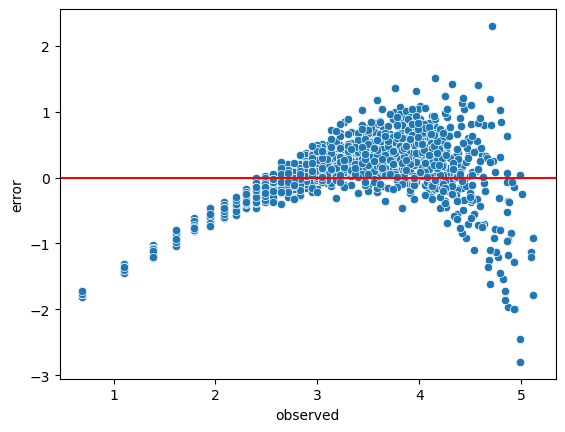

In [38]:
x = df_retards[features_selec]
y = df_retards['log_nb_train_retard_arrivee']

prediction(x, y)
print()

In [39]:
#Le modèle a toujours un problème de spécification mais est meilleur que le précédent